In [1]:
import random

from torch.nn.functional import relu6
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torchvision.datasets as tds
from torchvision.transforms import Lambda
import torchvision.transforms.functional as torchvisionF
from lovely_tensors import monkey_patch
monkey_patch()
import torch
from src.utils import XILUtils

device = XILUtils.define_device()
num_classes = 2

transform_func_device = Lambda(lambda i: torchvisionF.to_tensor(i).to(device=device))
ds_train = tds.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transform_func_device,
)

ds_test = tds.MNIST(
    root="data/",
    train=False,
    download=True,
    transform=transform_func_device,
)

train_dataset_length = -1

labels = [0, 8]
train_indices = [i for i, (_, label) in enumerate(ds_train) if label in labels][:train_dataset_length]
test_indices = [i for i, (_, label) in enumerate(ds_test) if label in labels]
ds_train = torch.utils.data.Subset(ds_train, train_indices)
ds_test = torch.utils.data.Subset(ds_test, test_indices)

# Set target_transform attribute
target_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float, device=device).scatter_(0, torch.tensor(0 if y == 0 else 1, device=device), value=1))
ds_train.dataset.target_transform = target_transform
ds_test.dataset.target_transform = target_transform

In [2]:
from torch.utils.data import DataLoader
tr = ds_train.dataset.target_transform
print(f"{ds_train.dataset.targets=}")


batch_size = 64

# create dataloader
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

train_dl_iterator = iter(train_dataloader)
test_dl_iterator = iter(test_dataloader)



ds_train.dataset.targets=tensor[60000] i64 0.5Mb x∈[0, 9] μ=4.454 σ=2.889


In [13]:
curr_batch = next(train_dl_iterator)
x_it, t_it = curr_batch

In [3]:
import torch
from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, Flatten, Linear, Softmax

class CustomModel(Module):
    def __init__(self, num_classes=10, device="cpu"):
        super(CustomModel, self).__init__()
        self.features = Sequential(
            # 1st group
            Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, device=device),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2, return_indices=True),
            # 2nd group
            Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, device=device),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        self.classifier = Sequential(
            Flatten(),
            Linear(in_features=32 * 7 * 7, out_features=128, device=device),  # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
            ReLU(),
            Linear(in_features=128, out_features=num_classes, device=device),
            Softmax(dim=1)
        )

    def forward(self, x):
        indices_list = []
        for layer in self.features:
            if isinstance(layer, MaxPool2d):
                x, indices = layer(x)
                indices_list.append(indices)
            else:
                x = layer(x)
        x = self.classifier(x)
        return x
    
    def __getitem__(self, idx):
        features_size = len(self.features)
        classifier_size = len(self.classifier)
        if idx < 0 or idx >= (features_size + classifier_size):
            raise RuntimeError(f"Index [{idx}] out of bounds")
        if idx < features_size:
            return self.features[idx]
        idx -= features_size
        return self.classifier[idx]


In [4]:
from pathlib import Path
model = CustomModel(num_classes=2, device=device)
DIR = Path("08_MNIST_output/")
model.load_state_dict(torch.load(DIR / "confounded_ds_model.pth", weights_only=True))
model.eval()

CustomModel(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)

In [16]:
with torch.no_grad():
    pred_it = model(x_it)

In [5]:
from pytorch_grad_cam import GradCAM
from src.guided_backprop import GuidedBackpropReLUModel

def guided_gradcam_explain(x_batch, model, device, target_layers):
    gb_model = GuidedBackpropReLUModel(model=model, device=device)
    
    model.eval()

    # Generate GradCAM
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = torch.tensor(cam(input_tensor=x_batch, targets=None, aug_smooth=False, eigen_smooth=False), device=device)
        gb_model_out = gb_model(x_batch, target_category=None)[:, 0, :, :]
        grayscale_cam *= gb_model_out
    
    return grayscale_cam
    

In [23]:
target_layers = [model[3]]
grayscale_explanation = guided_gradcam_explain(x_it, model, device, target_layers=target_layers)
grayscale_explanation = XILUtils.minmax_normalize_tensor(grayscale_explanation)


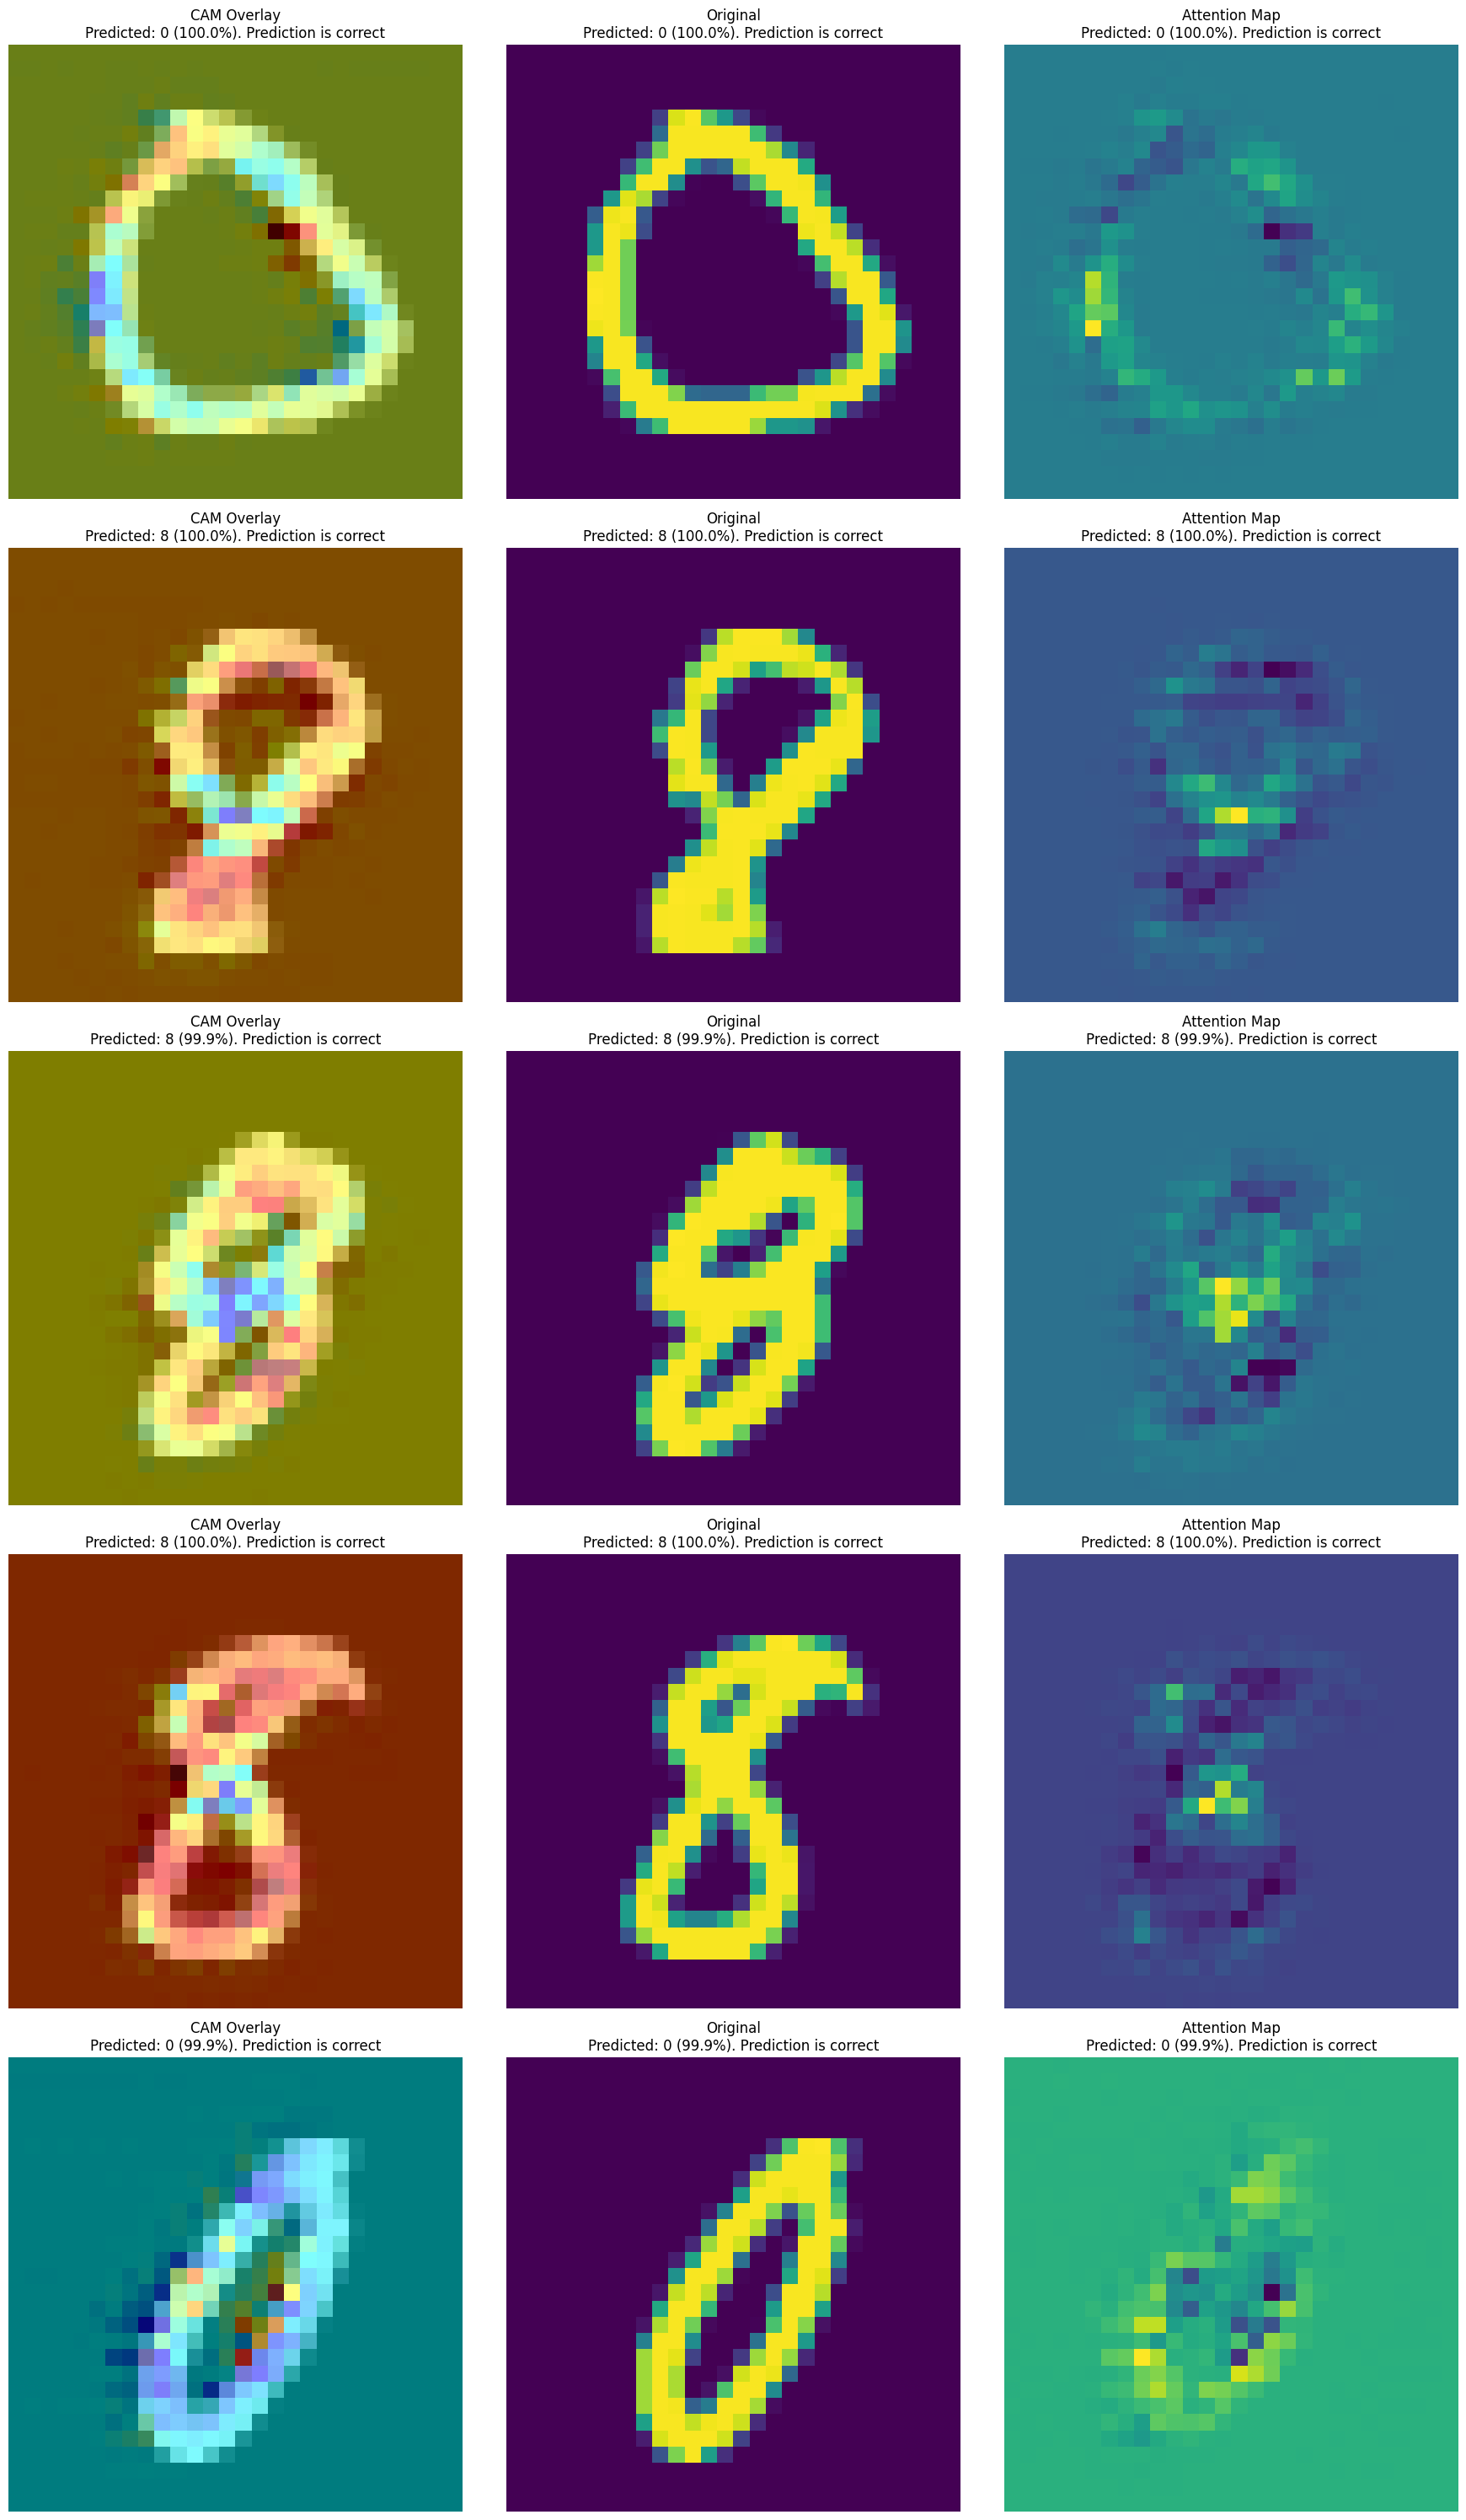

In [24]:
import matplotlib.pyplot as plt
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np

n_examples = 5
labels = [0, 8]

images = x_it.detach().cpu().numpy()
grayscale_maps = grayscale_explanation.cpu().numpy()
cam_images = []
for i in range(images.shape[0]):
    cam_images.append(show_cam_on_image(images[i].transpose((1, 2, 0)), grayscale_maps[i], use_rgb=False, image_weight=0.5))
predictions = pred_it.argmax(dim=1).cpu()
certainties = pred_it.max(dim=1).values.cpu() * 100
is_correct = (predictions == t_it.argmax(dim=1).cpu()).cpu()

XILUtils.plot_grad_cam(dict(
    images=images[:, 0, :, :], cam_images=cam_images, grayscale_maps=grayscale_maps, predictions=predictions,
                    certainties=certainties, is_correct=is_correct
),
labels,
n_examples,
plt)

## Confounding Dataset


In [18]:
def get_bottom_right_corner(image):
    # Remove the channel dimension
    tensor_2d = image.squeeze(0)
    # Find the indices where the tensor has non-zero values
    non_zero_indices = torch.nonzero(tensor_2d)
    # Get the maximum x, y indices
    max_x, max_y = non_zero_indices.max(dim=0).values
    return max_x.item(), max_y.item()

def write_dot_on_image(image, dot_sizes: torch.Size, padding=1):
    corner_x, corner_y = get_bottom_right_corner(image)
    binary_mask = torch.zeros_like(image)

    # Calculate the starting position of the dot outside the bounding box
    start_x = min(image.shape[2] - dot_sizes[1], corner_x + 1 + padding)
    start_y = min(image.shape[1] - dot_sizes[0], corner_y + 1 + padding)

    # Calculate the ending position of the dot
    end_x = min(image.shape[2], start_x + dot_sizes[1])
    end_y = min(image.shape[1], start_y + dot_sizes[0])

    # Draw the dot on the image
    image[0, start_y:end_y, start_x:end_x] = 1
    binary_mask[0, start_y:end_y, start_x:end_x] = 1

    return image, binary_mask


In [19]:
from src.rrr_dataset import RRRDataset
import random

inputs = []
targets = []
binary_masks = []

label_of_interest = torch.tensor((0, 1)) # eight
dot_sizes = [torch.Size((x, y)) for x in range(1, 4) for y in range (1, 4)]

for X, y in ds_train:
    if all(y.cpu() == label_of_interest):
        dot_size = random.choice(dot_sizes)
        input, binary_mask = write_dot_on_image(X, dot_size, padding=0)
        inputs.append(input)
        binary_masks.append(binary_mask)
    else:
        inputs.append(X)
        binary_masks.append(torch.zeros_like(X))

    targets.append(y)

misleading_ds_train = RRRDataset(torch.stack(inputs), torch.stack(targets), torch.stack(binary_masks))


/var/folders/9b/rkxr4tx941l76qtgtn679kth0000gn/T/ipykernel_36462/465511660.py:7: UserWarning: MPS: no support for int64 for min_max_out, downcasting to a smaller data type (int32/float32). Native support for int64 has been added in macOS 13.3. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:657.)
  max_x, max_y = non_zero_indices.max(dim=0).values


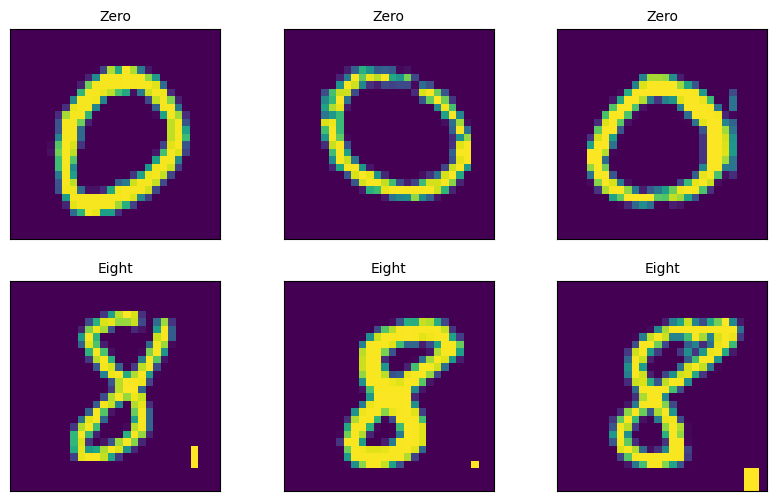

In [20]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
# fig.subplots_adjust(wspace=0, hspace=0)

# Show 3 instances for each of the 2 labels
label_translation = dict(zero=torch.tensor((1, 0), device=device), eight=torch.tensor((0, 1), device=device))
zeros = []
eights = []
example_dataloader = torch.utils.data.DataLoader(misleading_ds_train, batch_size=1, shuffle=True)
for i, (X, y, _) in enumerate(example_dataloader):
    X = torch.flatten(X, 0, 2)
    if all(y[0] == label_translation["zero"]) and len(zeros) != 3:
        zeros.append(X)
    elif all(y[0] == label_translation["eight"]) and len(eights) != 3:
        eights.append(X)

    if len(zeros) == 3 and len(eights) == 3:
        break

for i, X in enumerate(zeros):
    ax_list[0][i].imshow(X.cpu(), cmap='viridis')
    ax_list[0][i].set_title("Zero", fontsize=10, color='black')
    ax_list[0][i].set_xticks([])
    ax_list[0][i].set_yticks([])
    # ax_list[0][i].set_facecolor('black')

for i, X in enumerate(eights):
    ax_list[1][i].imshow(X.cpu(), cmap='viridis')
    ax_list[1][i].set_title("Eight", fontsize=10, color='black')
    ax_list[1][i].set_xticks([])
    ax_list[1][i].set_yticks([])



In [21]:
from src.caipi import RandomStrategy, to_counter_examples_2d_pic
def show_binary_masks(strat, is_substitution_strategy=False):
    # Show the binary masks
    original_pics = []
    titles_1 = []
    binary_masks = []
    titles_2 = []
    caipi = []
    titles_3 = []
    example_dataloader = torch.utils.data.DataLoader(misleading_ds_train, batch_size=1, shuffle=False)
    n_examples = 5
    for i, (x, y, R) in enumerate(example_dataloader):
        if all(y[0] == label_translation["zero"]):
            continue
        elif all(y[0] == label_translation["eight"]) and len(eights) != n_examples:
            prediction = model(x)
            prediction_correct = prediction.argmax() == 1
            prediction_certainty = prediction.max() * 100
            
            original_pics.append(x.cpu().view(28, 28))
            binary_masks.append(R.cpu().view(28, 28))
            if is_substitution_strategy:
                caipi_ce = to_counter_examples_2d_pic(strat, x, R.to(dtype=torch.bool), 1, target=y)[0]
            else:
                caipi_ce = to_counter_examples_2d_pic(strat, x, R.to(dtype=torch.bool), 1)[0]
                
            caipi.append(caipi_ce.cpu().view(28, 28))
            
            titles_1.append(f"Original\nPred: {prediction.argmax()}\nCertainty: {prediction_certainty:.2f}%\nCorrect: {prediction_correct}")
            titles_2.append("Binary Mask")
            titles_3.append("CAIPI")

        if len(original_pics) == n_examples:
            break
    columns = (original_pics, binary_masks, caipi)
    titles = (titles_1, titles_2, titles_3)
    XILUtils.plot_three_columns(plt, columns, n_examples, titles)

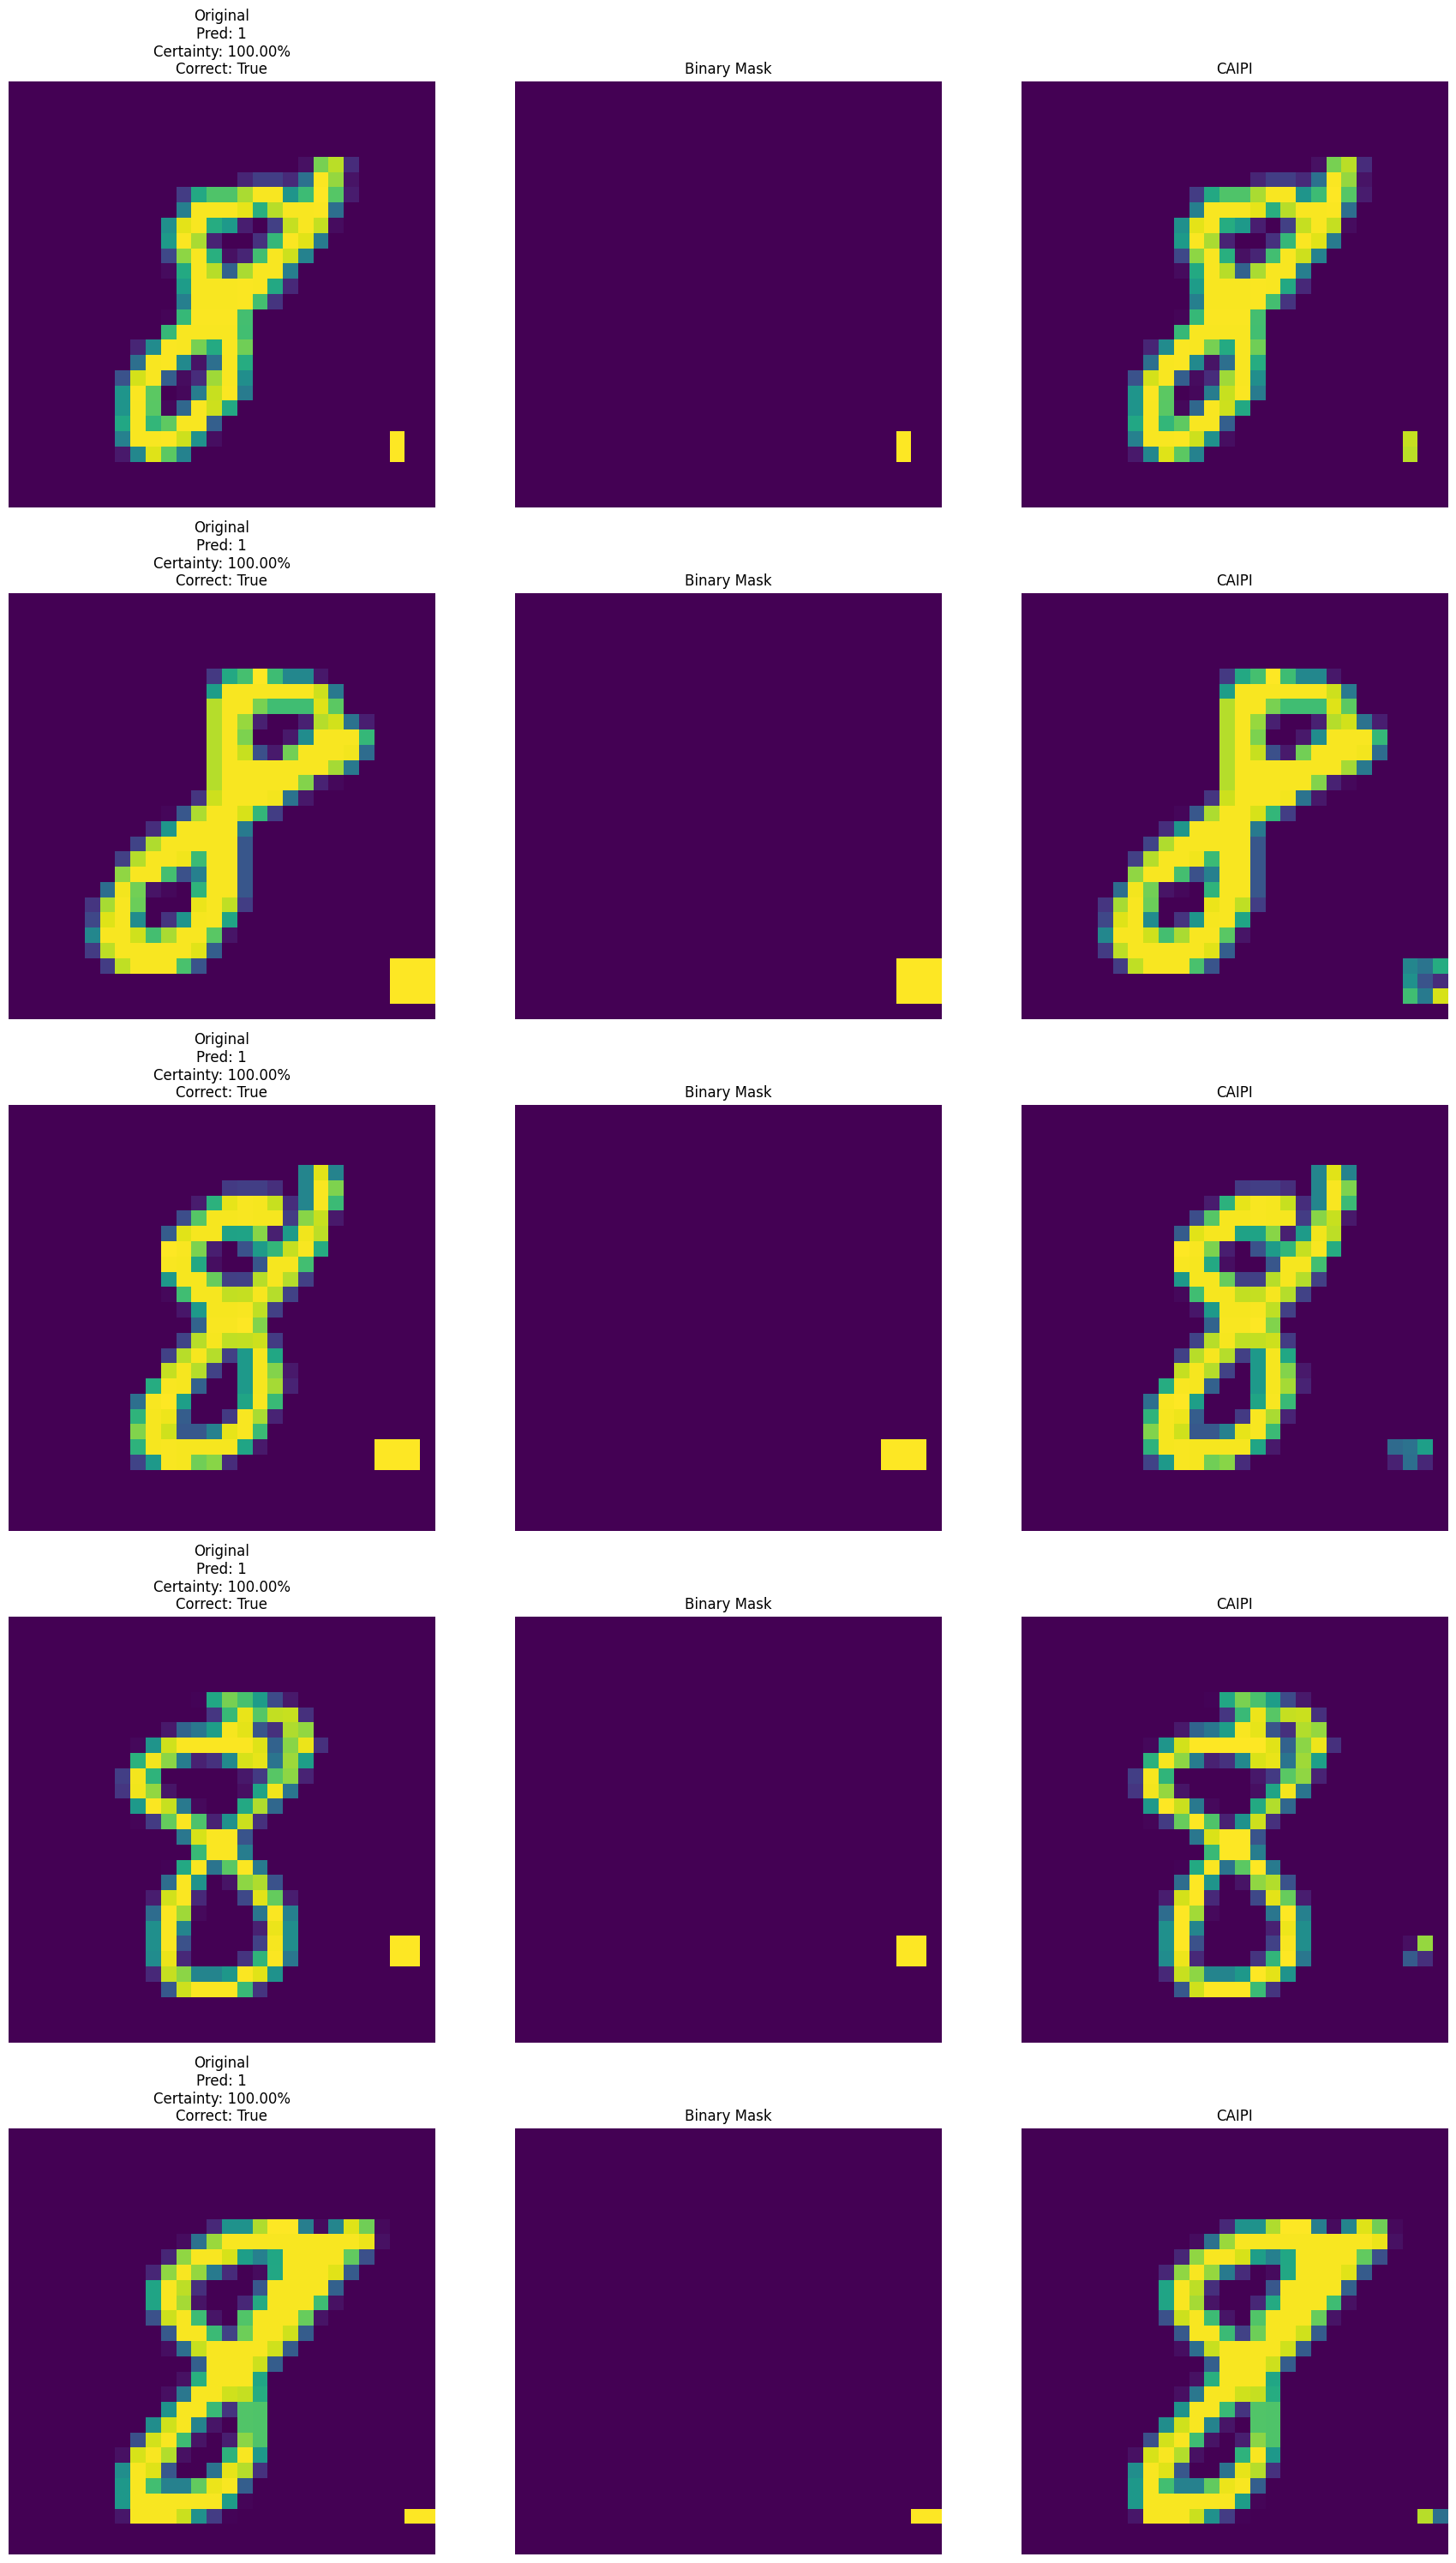

In [22]:

strategy = RandomStrategy(0., 1., torch.float32)
show_binary_masks(strategy)


### Substitution Strategy

In [25]:
from src.caipi import SubstitutionStrategy
dl = DataLoader(misleading_ds_train, batch_size=len(misleading_ds_train), shuffle=False)
inputs, targets, binary_masks = next(iter(dl))
substitution_strategy = SubstitutionStrategy(inputs, targets)

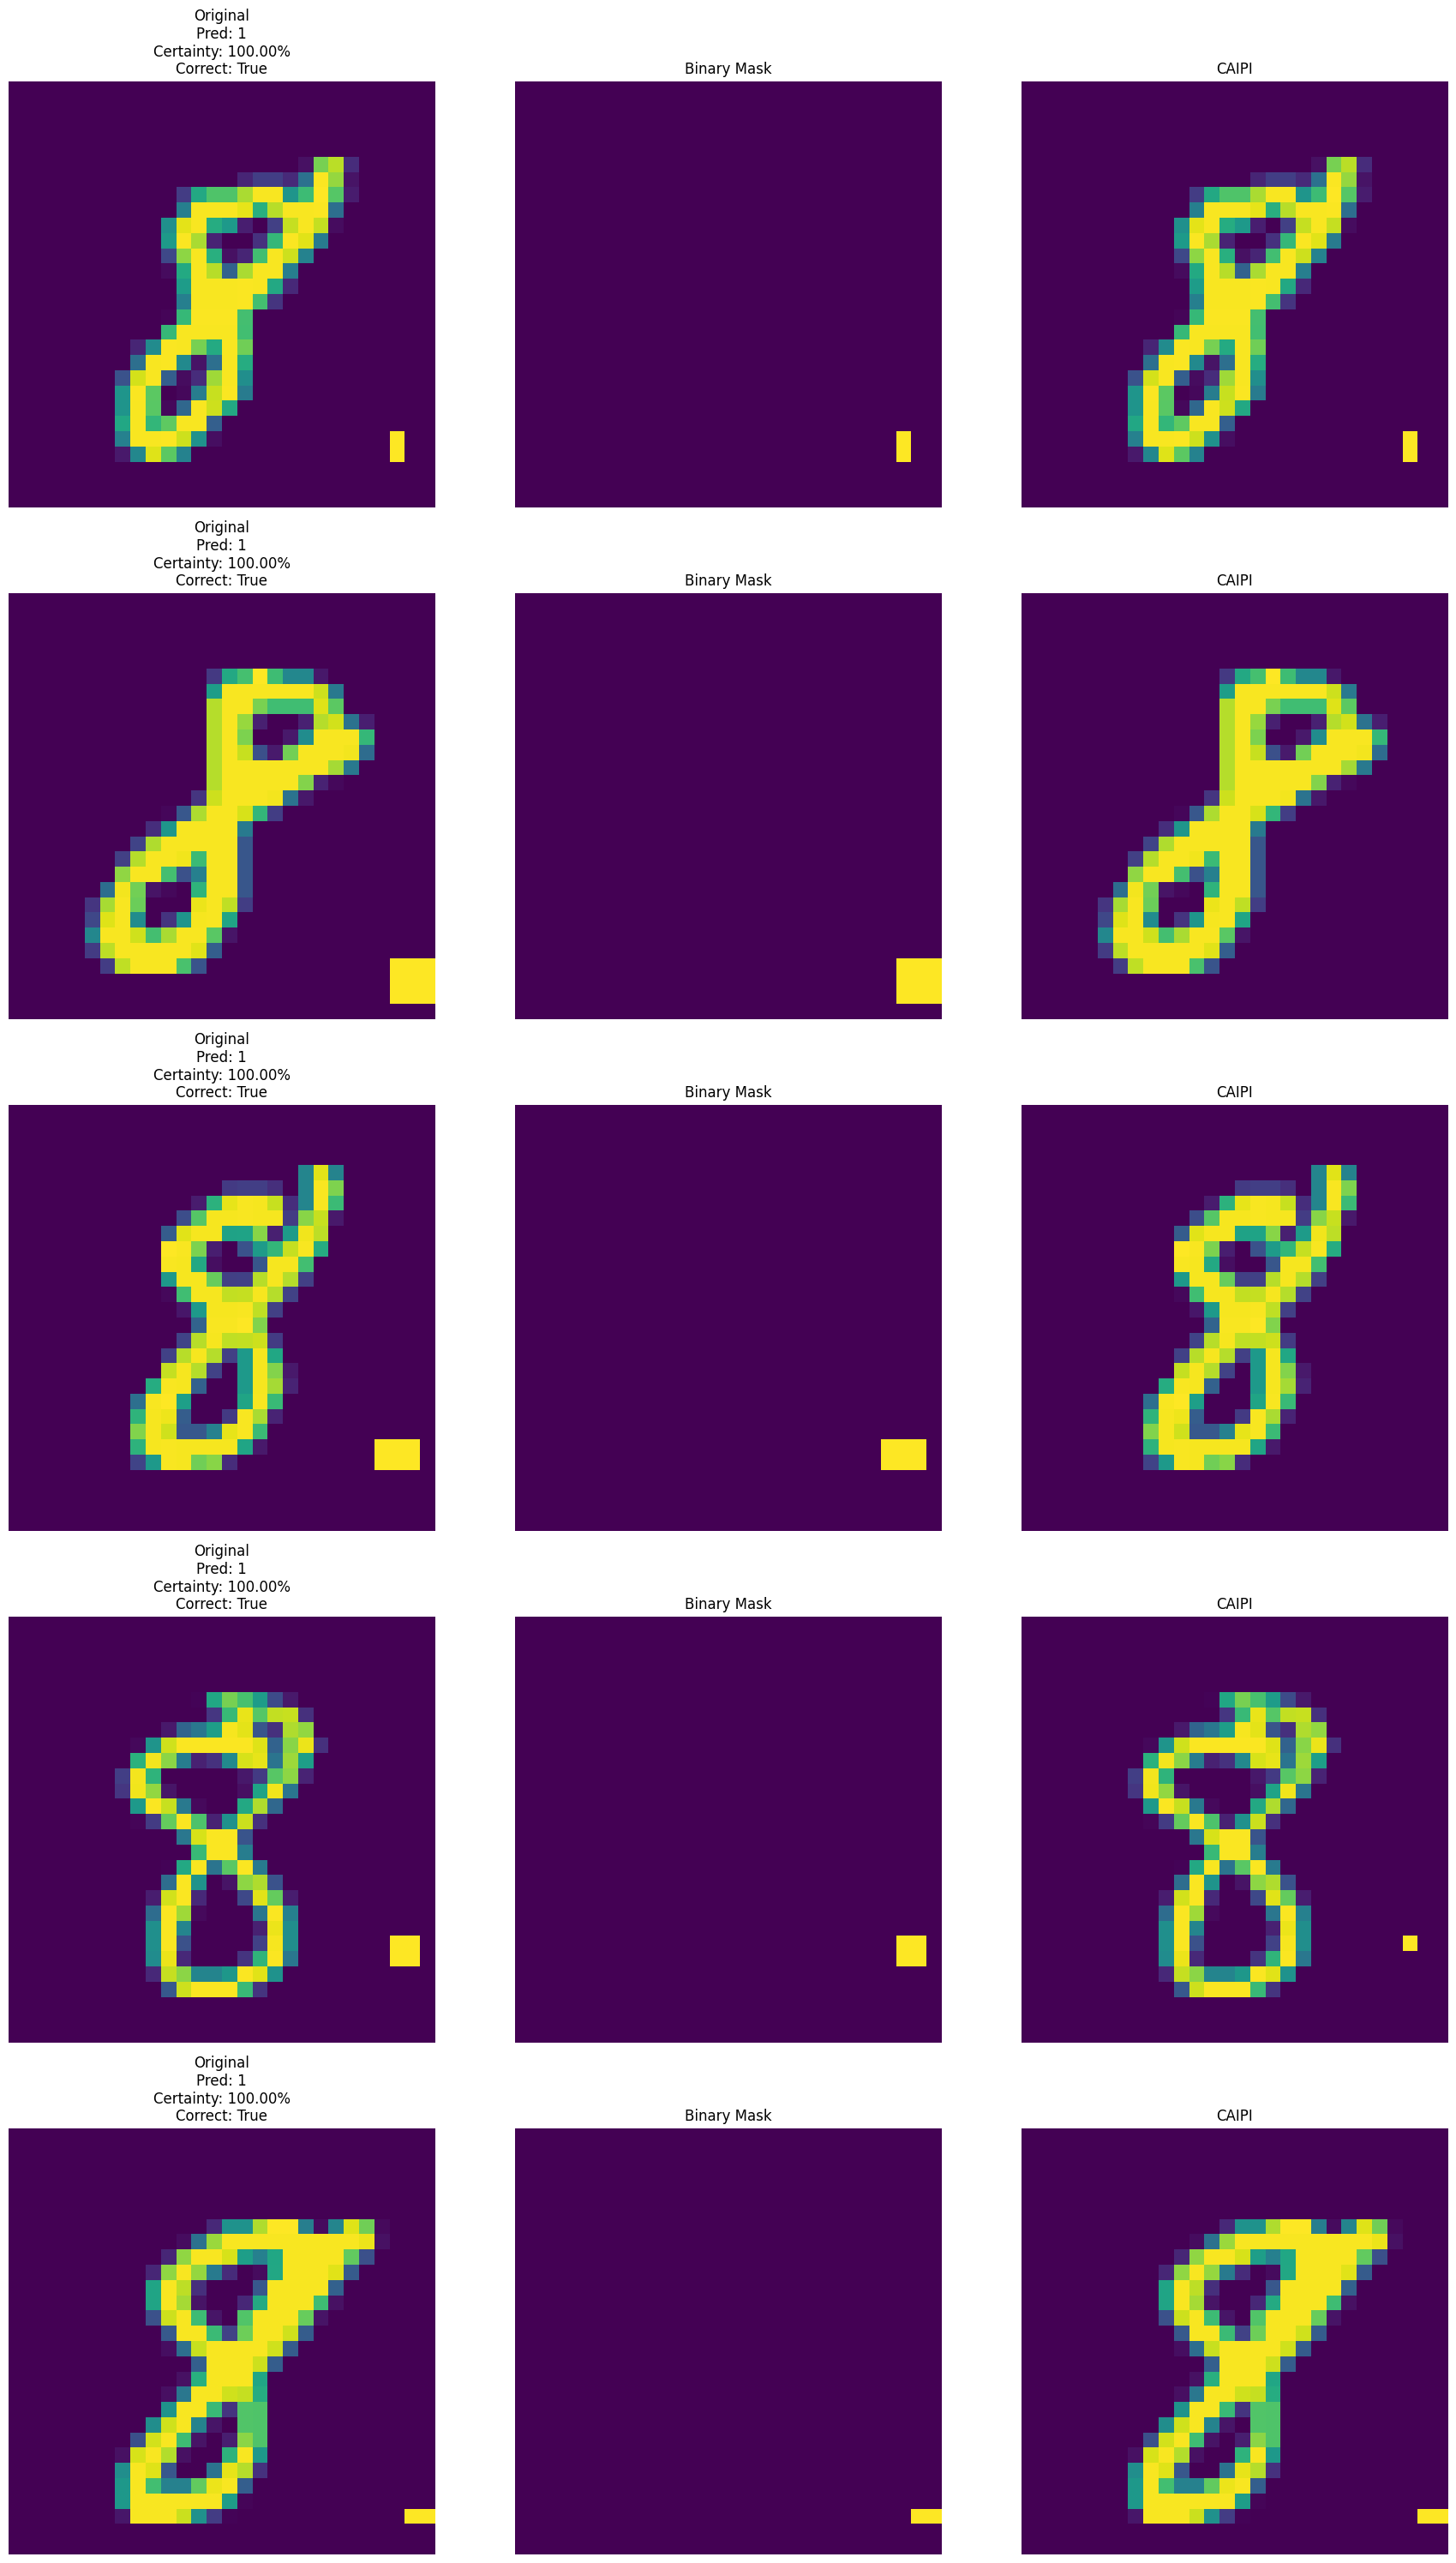

In [26]:
show_binary_masks(substitution_strategy, is_substitution_strategy=True)

### Alternative Value strategy

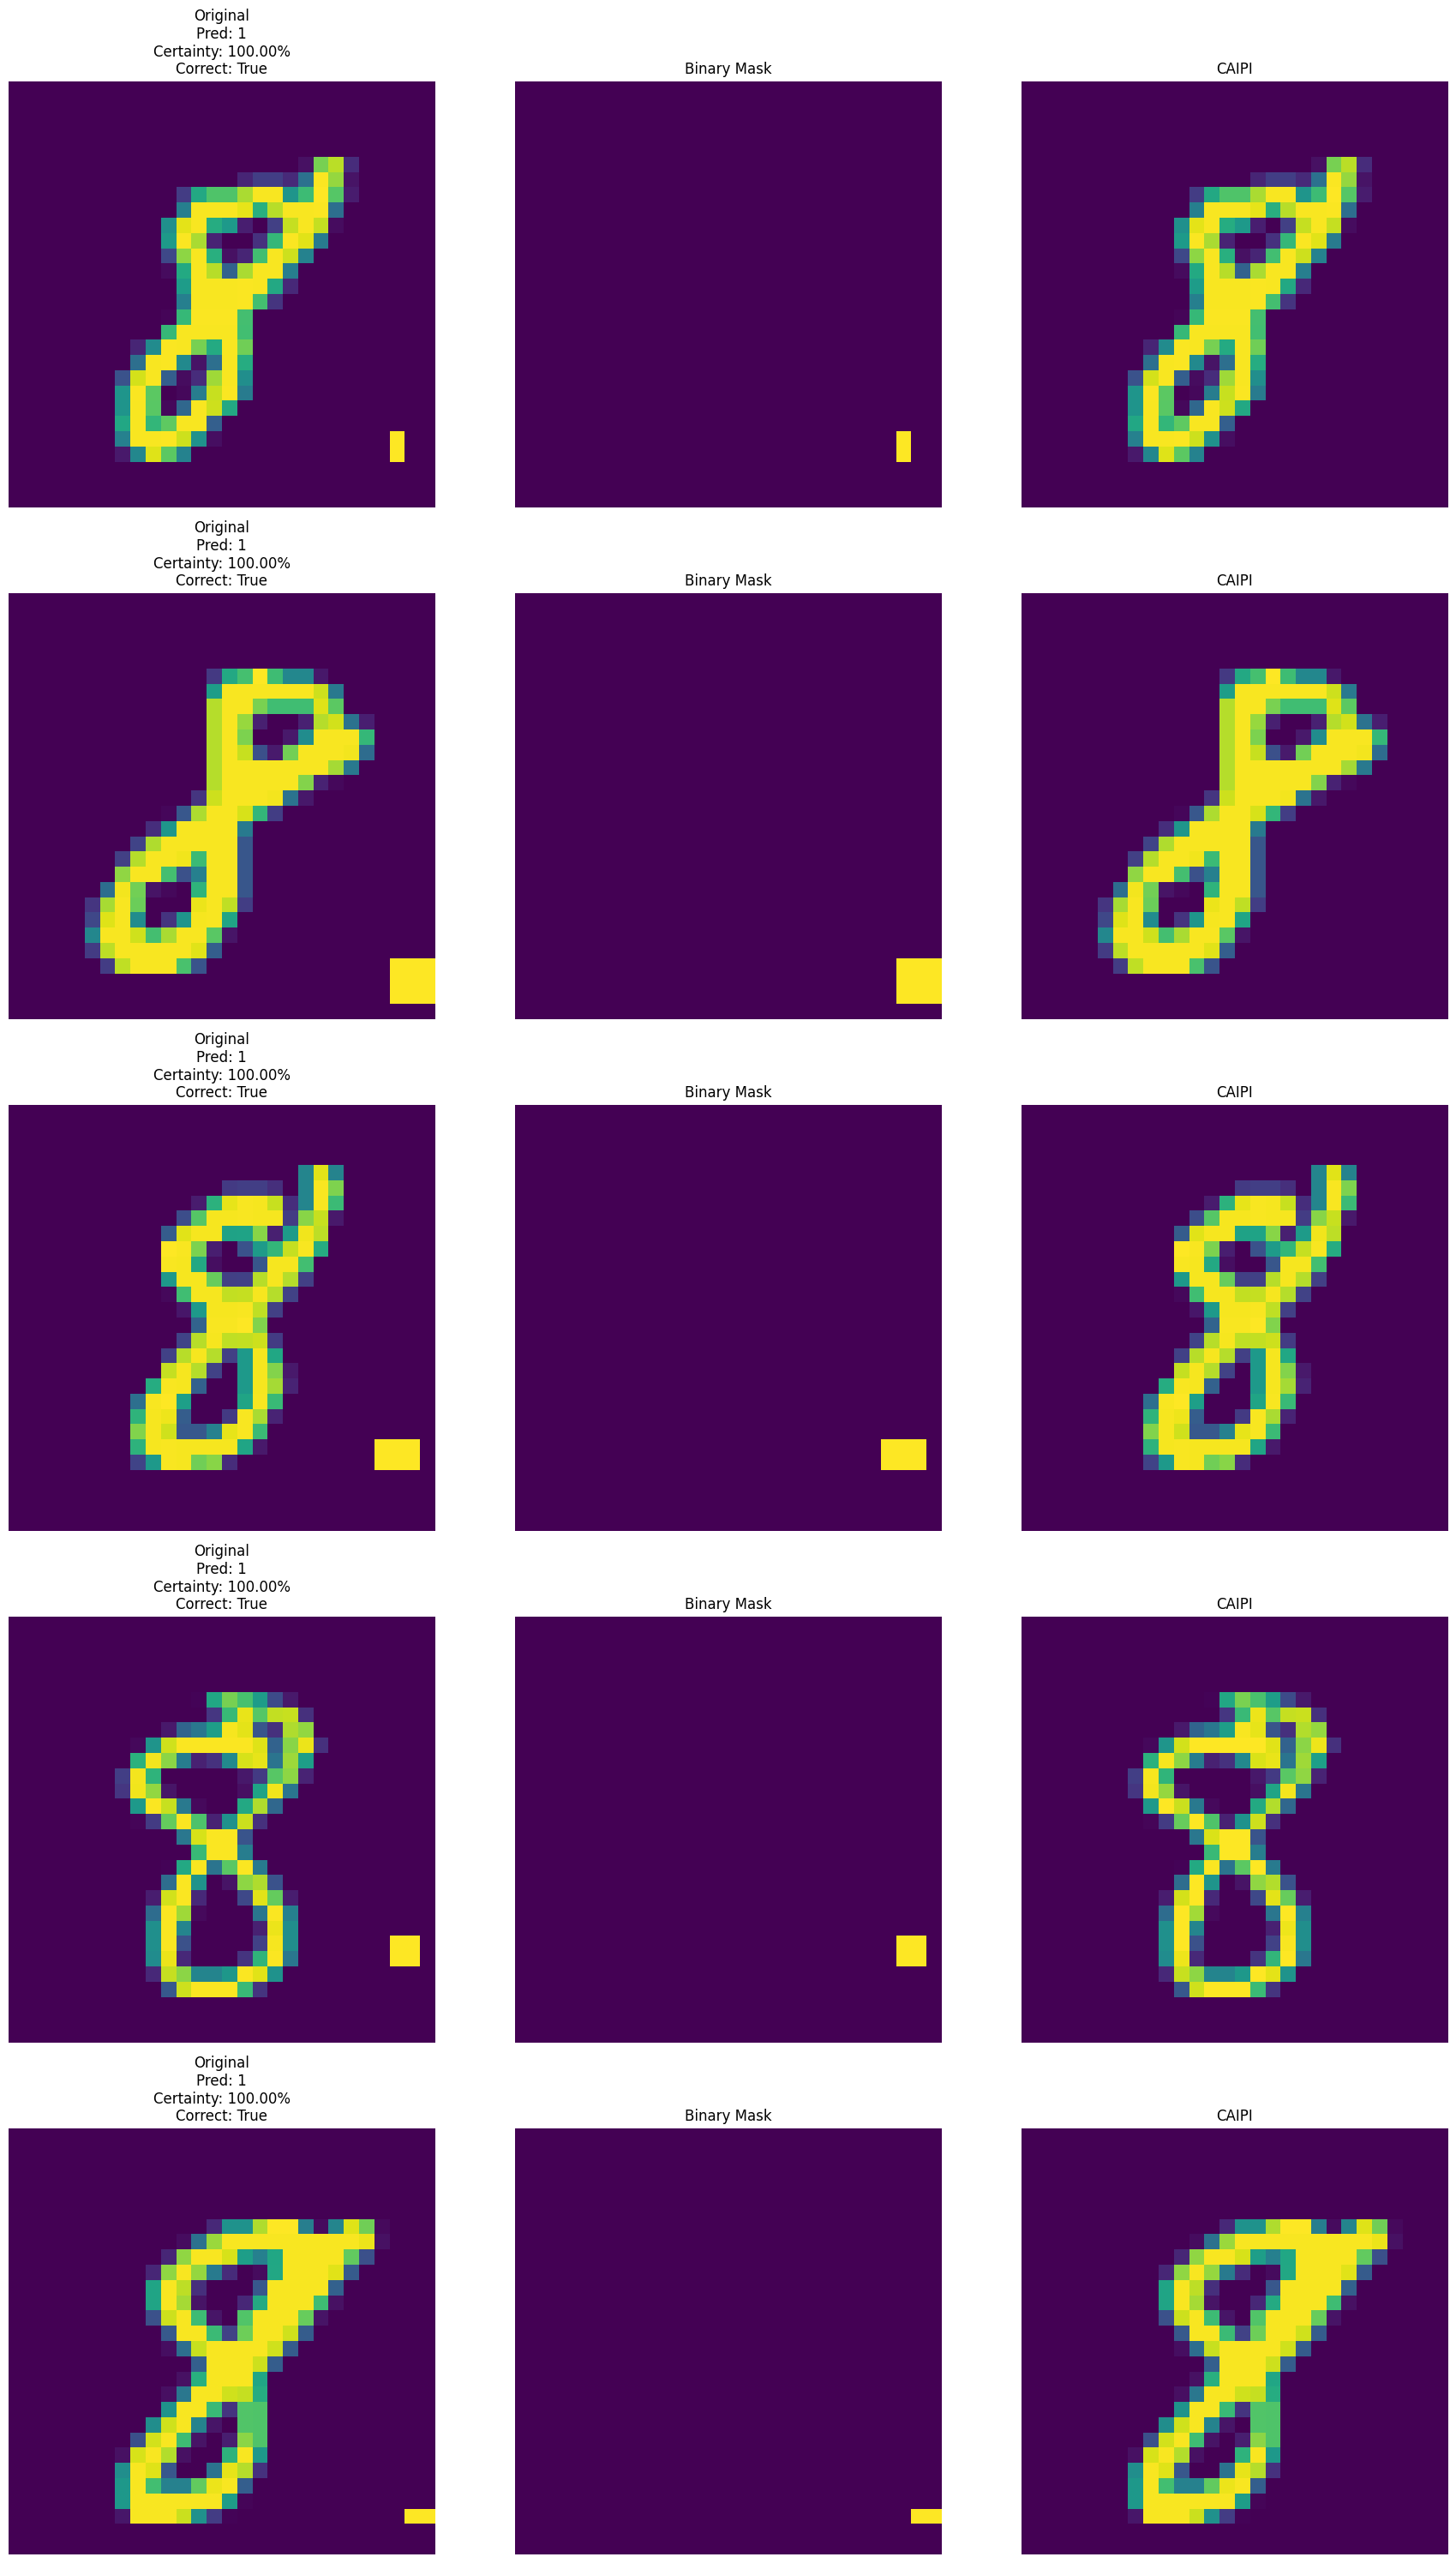

In [28]:
from src.caipi import AlternativeValueStrategy
image_shape = torch.Size((1, 1, 28, 28))
alt_strategy = AlternativeValueStrategy(torch.zeros(image_shape, device=device), torch.Size((1, 1, 28, 28)))

show_binary_masks(alt_strategy)